# Getting the rating from the reviews

In [75]:
# !pip install -q --disable-pip-version-check -r ../requirements.txt

In [3]:
# Matrix operations
import numpy as np

# Dataframes
import pandas as pd

# Charts
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# SciKit Learn Utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Horizontal stack in a less memory consuming approach
from scipy.sparse import hstack

# To perform Oversampling
import nlpaug.augmenter.word as naw

# Progress bar
from tqdm import tqdm

# PyTorch Dataset
import torch
from torch.utils.data import DataLoader, Dataset, random_split

# PyTorch Lightning NN Architecture
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning import Trainer

# PyTorch Lightning Callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

# Natural Language Toolkit
import nltk
from nltk.stem import SnowballStemmer
# from nltk.stem import WordNetLemmatizer   # Only for English
import re

# Language Detection
from langdetect import detect

# Word Embeddings
from nltk.tokenize import word_tokenize
from gensim.models import FastText

## GPU check

In [2]:
# Check for CUDA support
print("CUDA is available:", torch.cuda.is_available())

# Number of GPUs available
print("Number of GPUs:", torch.cuda.device_count())

# Current GPU
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.current_device())

    # GPU Name
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA is available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 2080 with Max-Q Design


## Preprocessing

### 1. Displaying the data

In [3]:
reviews_df = pd.read_csv('../data/Big_AHR.csv', index_col=0)
reviews_df.head()

,title,rating,review_text,location,hotel,label
0,Excelente y personal amable,5,Un hotel muy bueno. El personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
1,Céntrico,4,"Muy buen hotel al nivel de lo esperado, habita...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
2,Hotel excepcional,5,Magnífico hotel. La verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
3,WOW!!,5,"Hotel hermoso, buen diseño, original, limpio. ...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
4,Magnifico,5,Magnífica ubicación en pleno centro de Sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1


Obtain an example from the dataset:

In [4]:
def get_one_sample_with_columns(df, id=0):
    return list(zip(list(df.columns), list(df.iloc[id])))

Display the rating and the sentiment associated to the review:

In [5]:
def display_ratings(df):
    rating = df['rating'].value_counts()

    fig = px.bar(
        x=rating.index,
        y=rating.values,
        labels={'x': 'Rating', 'y': 'Count'},
        title='Count of Each Unique Rating'
    )

    fig.show()

In [6]:
def display_review_sentiment(df):
    SENTIMENT_CONVERSION = { 0: "Negative", 1: "Positive", 3: "Neutral" }

    sentiment_column = df['label'].value_counts().sort_index()

    fig = px.bar(
        # Convert numerical x-axis labels to string labels
        x=[SENTIMENT_CONVERSION[label] for label in sentiment_column.index],
        y=sentiment_column.values,
        labels={'x': 'Sentiment', 'y': 'Count'},
        title='Count of Each Unique Sentiment'
    )

    fig.show()

In [7]:
display_ratings(reviews_df)

In [8]:
display_review_sentiment(reviews_df)

As we can see, the dataset is completely unbalanced. There are almost 10x of 5-star ratings that 2-star ratings.

### 2. Combining the text features

Combining the title and the review_text attributes offer several advantages:

1. Contextual Information: Titles often provide a summary or highlight of the most important aspect of the review. We suspect that combining it with the review text can give the model more context, which might improve its understanding of the review sentiment.

2. Reducing Sparsity: We'll convert the text data into high-dimensional sparse vectors (e.g., via TF-IDF). If each text feature ('title' and 'review_text') is sparse and has little data, combining them can result in a less sparse representation, making it easier for the model to find patterns.

3. Noise Reduction: If one of the text features is noisy or less reliable, combining it with a more informative feature can help "average out" the noise, leading to a more robust representation.

In [9]:
if 'title' in reviews_df.columns.to_list() or 'review_text' in reviews_df.columns.to_list():
    reviews_df['text_content'] = reviews_df['title'] + ' ' + reviews_df['review_text']
    reviews_df = reviews_df.drop(columns=['title', 'review_text'])

Reorder the columns just to improve its readability:

In [10]:
new_column_order = ['location', 'hotel', 'text_content', 'label', 'rating']
reviews_df = reviews_df[new_column_order]

In [11]:
reviews_df.head()

,location,hotel,text_content,label,rating
0,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,Excelente y personal amable Un hotel muy bueno...,1,5
1,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,Céntrico Muy buen hotel al nivel de lo esperad...,1,4
2,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,Hotel excepcional Magnífico hotel. La verdad e...,1,5
3,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,"WOW!! Hotel hermoso, buen diseño, original, li...",1,5
4,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,Magnifico Magnífica ubicación en pleno centro ...,1,5


### 3. Removing NaN and missing values

In [12]:
def has_nan_or_missing_values(df):
    # Check for NaN values
    nan_check = df.isna().any()

    # Check for empty values (assuming empty strings)
    empty_check = (df == '').any()

    # Combine the results to check for both NaN and empty values
    has_nan_or_empty = nan_check | empty_check

    print(has_nan_or_empty)
    print(f"Number of samples: {df.shape[0]}")

In [13]:
has_nan_or_missing_values(reviews_df)

location         True
hotel            True
text_content    False
label           False
rating          False
dtype: bool
Number of samples: 18172


In [14]:
pd.unique(reviews_df['location'])[-5:]

array(['anlucar_de_Barrameda_Province_of_Cadiz_Andalucia',
       'Alajar_Sierra_de_Aracena_and_Picos_de_Aroche_Natural_Park_Pro',
       'Alajar_Sierra_de_Aracena_and_Picos_de_Aroche_Natural_Park_Province_of',
       'Tavira_Faro_District_Algarve', nan], dtype=object)

As we can see, there's a NaN so we'll remove it:  
(This will not really affect, since the NaN values are not in the columns we will use)

In [15]:
reviews_df = reviews_df.dropna(subset=['location'])

In [16]:
has_nan_or_missing_values(reviews_df)

location        False
hotel           False
text_content    False
label           False
rating          False
dtype: bool
Number of samples: 16356


✅ Removing the NaN values resulted on also removing the NaN and missing values from the hotel attribute.

In [17]:
get_one_sample_with_columns(reviews_df)

[('location', 'Seville_Province_of_Seville_Andalucia'),
 ('hotel', 'H10_Casa_de_la_Plata'),
 ('text_content',
  'Excelente y personal amable Un hotel muy bueno.  El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cómoda y limpia. Volvimos a próxima vez en Seville por seguro. Lo recomiendo !! Y también ubicación muy cerca del centro :))))'),
 ('label', 1),
 ('rating', 5)]

Obtain more information about the dataframe:

In [18]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16356 entries, 0 to 16355
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      16356 non-null  object
 1   hotel         16356 non-null  object
 2   text_content  16356 non-null  object
 3   label         16356 non-null  int64 
 4   rating        16356 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 766.7+ KB


Just for efficiency purposes, we can change the type of the label and rating columns:

In [19]:
reviews_df = reviews_df.astype({'label': 'uint8', 'rating': 'uint8'})

In [20]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16356 entries, 0 to 16355
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      16356 non-null  object
 1   hotel         16356 non-null  object
 2   text_content  16356 non-null  object
 3   label         16356 non-null  uint8 
 4   rating        16356 non-null  uint8 
dtypes: object(3), uint8(2)
memory usage: 543.1+ KB


### 4. Text Preprocessing

We will only keep the Spanish reviews with the langdetect library. Otherwise, the TF_IDF matrix will be too sparse.

In [21]:
# Remove all non-Spanish reviews
# --------------------------------------------------
# Commented, since it takes time to run
# and it can be loaded from the saved CSV file
# --------------------------------------------------

# reviews_df = reviews_df[reviews_df['text_content'].apply(lambda x: detect(x) == 'es')]
# reviews_df.info()

In [97]:
# Reset the indeces
# reviews_df = reviews_df.reset_index(drop=True)

In [22]:
# Save the dataframe to a CSV file
# reviews_df.to_csv('../data/Big_AHR_Spanish.csv')

In [99]:
# Import the CSV file
reviews_df = pd.read_csv('../data/Big_AHR_Spanish.csv', index_col=0)

In [100]:
display_ratings(reviews_df)

### 5. Balance the data

We need to first split the data into train , validation and test, so that we don't leak information from the test set into the training set.

In [107]:
def split_dataset_balanced(dataframe, validation_size, test_size, num_classes=5, seed=33):
    """
    Gets a balanced split for validation and test sets from a dataframe.
    """
    # Shuffle the dataframe
    dataframe = shuffle(dataframe, random_state=seed)

    # Get the first (validation_count // num_classes) samples from each class
    validation_df = dataframe.groupby('rating').head(validation_size // num_classes)

    # Get the first (test_count // num_classes) samples from each class
    test_df = dataframe.groupby('rating').tail(test_size // num_classes)

    # Get the remaining samples
    train_df = dataframe.drop(validation_df.index).drop(test_df.index)

    # Reset the indeces
    train_df = train_df.reset_index(drop=True)
    validation_df = validation_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    return train_df, validation_df, test_df   

After removing the non-Spanish reviews, we can see that the class with the least amount of samples is the 2-star rating. We cannot take a lot of samples from it, because we already have very few. We will split the dataset by taking 70 samples from each class for both the validation and test sets. The remaining samples will be used for training.

In [108]:
display_ratings(reviews_df)

In [109]:
# Split the data into train, validation, and test set
print(f"Total number of examples: {reviews_df.shape[0]}")
train_df, val_df, test_df = split_dataset_balanced(reviews_df, 350, 350)
print(f"Number of training examples: {train_df.shape[0]}")
print(f"Number of validation examples: {val_df.shape[0]}")
print(f"Number of testing examples: {test_df.shape[0]}")

Total number of examples: 16011
Number of training examples: 15311
Number of validation examples: 350
Number of testing examples: 350


In [110]:
display_ratings(train_df)

In [111]:
display_ratings(val_df)

In [112]:
display_ratings(test_df)

Now we cut all the classes from the training set at 2000 samples, so that we have a more balanced dataset.

In [113]:
# Cut the all training classes to 2000 samples
train_df = train_df.groupby('rating').head(2000).reset_index(drop=True)

In [114]:
display_ratings(train_df)

Once we have classes that are not so unbalanced, we can oversample the minority classes. We will use synonims substitution to generate new samples.

For that, we'll use the library nlpaug which will allow us to perform text augmentation by using synonyms.

In [115]:
# Download wordnet package if you haven't
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [116]:
aug = naw.SynonymAug(aug_src='wordnet', lang='spa', aug_max=100)

def augment_text(text):
    return aug.augment(text)[0]

In [117]:
def oversample(reviews_df, target_samples):
    new_reviews = []

    for rating, target_count in tqdm(target_samples.items(), desc='Oversampling Ratings', unit='rating', total=len(target_samples)):
        # Filter reviews with the current rating
        ratings = reviews_df[reviews_df['rating'] == rating] 

        if target_count > len(ratings):
            # Number of samples to generate
            oversample_count = target_count - len(ratings)
            
            for _ in range(oversample_count):
                # Randomly select a review to augment
                row = ratings.sample(1).iloc[0]
                
                augmented_text = augment_text(row['text_content'])
                
                new_reviews.append({'location': row['location'],
                                    'hotel': row['hotel'],
                                    'text_content': augmented_text,
                                    'label': row['label'],
                                    'rating': rating})

    return pd.DataFrame(new_reviews)

In [118]:
# Augment the reviews up to a desired percentage of each rating
def oversample_percentage(reviews_df, percentage):
    # Get the number of samples for each rating
    rating_counts = reviews_df['rating'].value_counts()

    # Get the target number of samples for each rating by multiplying by (100 + percentage) / 100
    target_samples = (rating_counts * (100 + percentage) / 100).astype('int')

    return oversample(reviews_df, target_samples)   

In [119]:
max_rating_samples = max([len(train_df[train_df['rating'] == rating]) for rating in [1,2,3,4,5]])
print(f"Maximum number of samples in a rating: {max_rating_samples}")

Maximum number of samples in a rating: 2000


In [120]:
target_samples = {1: max_rating_samples, 2: max_rating_samples, 3: max_rating_samples, 4: max_rating_samples, 5: max_rating_samples}
new_df = oversample(train_df, target_samples)   # Contains only the augmented reviews

In [ ]:
new_df

,location,hotel,text_content,label,rating
0,Almeria_Province_of_Almeria_Andalucia,Hotel_Catedral_Almeria,Daño inodoro y mala atención tras Queja No me ...,0,1
1,Cordoba_Province_of_Cordoba_Andalucia,Hotel_Abetos_del_Maestre_Escuela,Wc estado diamante restauración PÉSIMO El serv...,0,1
2,Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Bellavista_Playa_Malaga,"Error Fuimos por la ubicación, habíamos pasado...",0,1
3,Seville_Province_of_Seville_Andalucia,Hotel_San_Gil,NO VOLVERÉ El hotel dice ser un cuatro estrell...,0,1
4,Almeria_Province_of_Almeria_Andalucia,La_Gallineta_de_Gata,"Bochornoso, lamentable! 0% recomendable, razon...",0,1
...,...,...,...,...,...
2333,Cordoba_Province_of_Cordoba_Andalucia,Hotel_Gonzalez,Económico y céntrico Este humilde hotel está a...,3,3
2334,Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Hotel_Plaza_Del_Castillo,En medio estado diamante la nada Hotel situado...,3,3
2335,Granada_Province_of_Granada_Andalucia,Hotel_Plaza_Nueva,Muy buena ubicación El hotel está situado en u...,3,3
2336,Cordoba_Province_of_Cordoba_Andalucia,Cordoba_Inturjoven_Youth_Hostel,Muy básico Situación sorprendente en pleno meo...,3,3


Append augmented data to the original dataframe

In [ ]:
train_df = pd.concat([train_df, new_df], axis=0)

Shuffle the data:

In [ ]:
train_df = shuffle(train_df).reset_index(drop=True)

As we can see, now the dataset are more balanced:

In [ ]:
display_ratings(train_df)

In [ ]:
display_review_sentiment(train_df)



Note that text generation is just one way to oversample text data, and it may not always be the best approach depending on your specific use case. You may want to consider other oversampling techniques such as SMOTE or ADASYN as well.

We will do some preprocessing to see if we can improve the results of the model. We will remove the stopwords and do stemming.

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords

In [5]:
# Initialize stop words and stemmer
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

In [6]:
# Define the text preprocessing function
def preprocess(text):
    text = re.sub(r'\W', ' ', text)  # Replace non-word characters with a space
    text = text.lower()  # Convert to lowercase
    words = text.split()  # Split text into words
    words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stop words and stem
    return ' '.join(words)

In [8]:
train_df_stemming = train_df.copy()
val_df_stemming = val_df.copy()
test_df_stemming = test_df.copy()

train_df_stemming['text_content'] = train_df_stemming['text_content'].apply(preprocess)
val_df_stemming['text_content'] = val_df_stemming['text_content'].apply(preprocess)
test_df_stemming['text_content'] = test_df_stemming['text_content'].apply(preprocess)


### 6. Save balanced dataset

In [ ]:
train_df.to_csv('../data/Big_AHR_Balanced_train.csv')
val_df.to_csv('../data/Big_AHR_Balanced_val.csv')
test_df.to_csv('../data/Big_AHR_Balanced_test.csv')

In [9]:
train_df_stemming.to_csv('../data/Big_AHR_Balanced_train_stemming.csv')
val_df_stemming.to_csv('../data/Big_AHR_Balanced_val_stemming.csv')
test_df_stemming.to_csv('../data/Big_AHR_Balanced_test_stemming.csv')

If the datasets are not defined (in case we jump directly to point 5), import it:

In [2]:
if not 'train_df' in locals():
    train_df = pd.read_csv('../data/Big_AHR_Balanced_train.csv', index_col=0)

if not 'val_df' in locals():
    val_df = pd.read_csv('../data/Big_AHR_Balanced_val.csv', index_col=0)

if not 'test_df' in locals():
    test_df = pd.read_csv('../data/Big_AHR_Balanced_test.csv', index_col=0)

In [8]:
# balanced, stemming
DATASET_SELECTION = 'balanced'

In [9]:
if DATASET_SELECTION == 'balanced':
    train_df = pd.read_csv('../data/Big_AHR_Balanced_train.csv', index_col=0)
    val_df = pd.read_csv('../data/Big_AHR_Balanced_val.csv', index_col=0)
    test_df = pd.read_csv('../data/Big_AHR_Balanced_test.csv', index_col=0)

elif DATASET_SELECTION == 'stemming':
    train_df = pd.read_csv('../data/Big_AHR_Balanced_train_stemming.csv', index_col=0)
    val_df = pd.read_csv('../data/Big_AHR_Balanced_val_stemming.csv', index_col=0)
    test_df = pd.read_csv('../data/Big_AHR_Balanced_test_stemming.csv', index_col=0)


### 7. Convert the text data into numerical format using TF-IDF

We've to convert the text data (which is the attribute text_content) into a numerical format so it could be used by the neural network. In order to do this, we'll use TF-IDF (Term Frequency - Inverse Document Frequency), which is a technique to quantify words in a set of documents:

In [4]:
tfidf_vectorizer = TfidfVectorizer(max_features=500)
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)

# Learn vocabulary and idf from training set
tfidf_vectorizer.fit(train_df['text_content'])

# Transform documents to document-term matrix.
train_text_features = tfidf_vectorizer.transform(train_df['text_content'])
val_text_features = tfidf_vectorizer.transform(val_df['text_content'])
test_text_features = tfidf_vectorizer.transform(test_df['text_content'])

In [5]:
print("train_text_features shape: " + str(train_text_features.shape))
print("val_text_features shape: " + str(val_text_features.shape))
print("test_text_features shape: " + str(test_text_features.shape))

train_text_features shape: (10000, 500)
val_text_features shape: (350, 500)
test_text_features shape: (350, 500)


In [ ]:
# print(f"Number of categorical features: {categorical_features.shape[1]}")
# print(f"Number of samples: {text_features.shape[0]}")

Number of categorical features: 724
Number of samples: 10700


### 8. Join the one-hot-encoded data and the text in numerical format

In [ ]:
# combined_features = hstack([categorical_features, text_features]).tocsr()

### 9. Visualize the features using T-SNE by applying Dimensionality Reduction (Optional)

In [6]:
# Dimensionality reduction to improve the visualization
# - We're reducing to 50 components as an example, but this can be changed
svd = TruncatedSVD(n_components=50)
reduced_features = svd.fit_transform(train_text_features)

Apply T-SNE (this lasts ~1 min):

In [7]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_features)

In [8]:
# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(data={
    'X': tsne_results[:, 0],
    'Y': tsne_results[:, 1],
    'Rating': train_df['rating'],
    'Label': train_df['label']
})

# Plot using Plotly with Rating as color and Label as marker style
fig = px.scatter(tsne_df, x='X', y='Y', color='Rating', symbol='Label', 
                 color_continuous_scale='viridis', 
                 title="t-SNE Visualization of Reviews",
                 symbol_map={0: 'circle', 1: 'square', 3: 'cross'}
                )

# Adjust the order of the legends
fig.update_layout(coloraxis_colorbar=dict(title='Rating', yanchor="top",
                  y=1, x=0, ticks="outside"))
fig.update_xaxes(title_text='t-SNE Component 1')
fig.update_yaxes(title_text='t-SNE Component 2')
fig.show()


Convert the features into dataframes:

In [5]:
train_text_features_df = pd.DataFrame(train_text_features.toarray())
val_text_features_df = pd.DataFrame(val_text_features.toarray())
test_text_features_df = pd.DataFrame(test_text_features.toarray())

⚠️ Only execute the cells from the section 10.1 or 10.2, not both.

#### 10.1. Predict the label

In [6]:
# convert all the values of the label column that have a value of 3 to 2
X_train = train_text_features_df
y_train = train_df['label'].replace(3, 2)

X_val = val_text_features_df
y_val = val_df['label'].replace(3, 2)

X_test = test_text_features_df
y_test = test_df['label'].replace(3, 2)

#### 10.2. Predict the rating

Split the data into train and test:

In [8]:
X_train = train_text_features_df
y_train = train_df['rating']

X_val = val_text_features_df
y_val = val_df['rating']

X_test = test_text_features_df
y_test = test_df['rating']

As we can see, now we have:

- Training: X_train, y_train.

- Validation: X_val, y_val.

- Testing: X_test, y_test.

Finally, keep in mind that the PyTorch model will work with values in a range starting from 0. Therefore, we have to convert the range of the y values from 1-5 to 0-4:

In [7]:
# Only the 'rating' needs to be displaced by 1
# The 'label' already starts at 0
if len(y_train.unique()) == 5:
    # Convert the labels to start from 0 instead of 1
    y_train = y_train - 1
    y_val = y_val - 1
    y_test = y_test - 1

# Display the classes
print(f"Classes: {np.unique(y_train)}")

Classes: [0 1 2]


## Model

In [32]:
BATCH_SIZE = 32
NUM_EPOCHS = 50

Make the code more reproducible:

In [33]:
torch.manual_seed(23)  

### 1. Define a PyTorch dataset and dataloader

In [34]:
class ReviewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [45]:
train_dataset = ReviewsDataset(torch.tensor(X_train.values).float(), torch.tensor(y_train.values).long())
val_dataset = ReviewsDataset(torch.tensor(X_val.values).float(), torch.tensor(y_val.values).long())
test_dataset = ReviewsDataset(torch.tensor(X_test.values).float(), torch.tensor(y_test.values).long())

In [46]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 2. Neural Network Architecture using PyTorch Lightning

In [47]:
input_dim = X_train.shape[1]
output_dim = y_train.nunique()

print(f"Input dimension: {input_dim} (input neurons)\nOutput dimension: {output_dim} (num of different ratings)")

Input dimension: 128 (input neurons)
Output dimension: 5 (num of different ratings)


In [48]:
class ReviewClassifier(pl.LightningModule):
    def __init__(self, layers):
        super(ReviewClassifier, self).__init__()
        self.layers = layers
        self.network = torch.nn.Sequential(*self.layers)

        # Trackers for our desired metrics
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []
        self.val_f1_scores = []
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.accuracy_outputs = []
        self.f1_score_outputs = []
    
    def forward(self, x):
        return self.network(x)
    
    def training_step(self, batch, batch_idx):
        # Obtaining the x and y value of a batch from the dataset with size BATCH_SIZE
        x, y = batch
        # Predict the value of y using x
        y_hat = self(x)

        # Loss Function: We'll use the Cross-Entropy Loss as it's a loss function used for multi-class
        # classification problems (thanks to using the softmax activation function)
        loss = F.cross_entropy(y_hat, y)
        self.training_step_outputs.append(loss)

        return loss

    def on_train_epoch_end(self, *args, **kwargs):
        # Compute the average training loss over the epoch and add it to the list of losses
        avg_train_loss = torch.stack(self.training_step_outputs).mean()
        self.training_step_outputs.clear()
        self.train_losses.append(avg_train_loss)
    
    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        avg_acc = sum(self.accuracy_outputs) / len(self.accuracy_outputs)
        avg_f1_score = sum(self.f1_score_outputs) / len(self.f1_score_outputs)
        self.validation_step_outputs.clear()
        self.accuracy_outputs.clear()
        self.f1_score_outputs.clear()
        
        self.val_losses.append(avg_val_loss)
        self.val_accs.append(avg_acc)
        self.val_f1_scores.append(avg_f1_score)
        
        metrics = {'val_loss': avg_val_loss, 'val_acc': avg_acc, 'val_f1_score': avg_f1_score}
        return {'val_loss': avg_val_loss, 'progress_bar': metrics}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.validation_step_outputs.append(val_loss)
        # We'll use the accuracy as the metric for the classification problem
        # - pred_val = torch.argmax in dim=1 (y-axis): [[0.1, 0.8, 0.1], 
        #                                               [0.7, 0.1, 0.2]] -> output: [1, 0]
        # - v = torch.sum(pred_val == [1, 1]) -> output: sum([True, False]) -> output: 1 (.item() gets the val)
        # - v / [1, 1].shape[0] -> output: 1 / 2 -> 50% of accuracy
        y_hat_classes = torch.argmax(y_hat, dim=1)
        val_acc = torch.sum(y_hat_classes == y).item() / y.shape[0]
        # Copy y_hat and y to numpy arrays to be able to use the f1_score function
        # We use the sklearn.metrics.f1_score function to compute the F1 score
        # instead of the one from PyTorch because it doesn't support label specification
        y_hat_classes_np = y_hat_classes.cpu().detach().numpy()
        y_np = y.cpu().detach().numpy()
        # We only want to take into accont the labels that are present in the batch
        val_f1_score = f1_score(y_hat_classes_np, y_np, labels=np.unique(y_hat_classes_np), average='weighted')
        # print("y_hat: " + str(torch.argmax(y_hat, dim=1)))
        # print("y: " + str(y))
        # print("y_hat_len: " + str(len(torch.argmax(y_hat, dim=1))))
        # print("y_len: " + str(len(y)))

        self.accuracy_outputs.append(val_acc)
        self.f1_score_outputs.append(val_f1_score)

        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc)
        self.log('val_f1_score', val_f1_score)

        return {'val_loss': val_loss, 'val_acc': val_acc, 'val_f1_score': val_f1_score}
    
    def configure_optimizers(self):
        # We'll use Adam as the optimizer as it has shown pretty good results in a lot of
        # tasks where classification is performed
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=0.001,
            weight_decay=1e-5 # L2 Regularization to prevent overfitting
        )

        # ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
        # - mode: 'min' if the metric is the loss, 'max' if the metric is accuracy
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            },
        }

In [49]:
layers1 = [
    torch.nn.Linear(input_dim, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, output_dim)
]

layers2 = [
    torch.nn.Linear(input_dim, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(128, output_dim)
]

layers3 = [
    torch.nn.Linear(input_dim, 2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.75),

    torch.nn.Linear(2048, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),

    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(128, output_dim)
]

In [50]:
model = ReviewClassifier(layers2)

### 3. Training the model

Save the model every 5 epochs:

In [51]:
checkpoint_callback = ModelCheckpoint(
    filename='models/review_classifier_{epoch:02d}_{val_acc:.2f}',
    save_top_k=1,  # Save only the best model
    save_last=True,  # Save the model from the last epoch
    verbose=True,  # Print a message whenever a new top model is found
    monitor='val_acc',  # Decide what metric to monitor for model saving
    mode='max',  # Best model will be the one with the greatest 'val_acc'
    every_n_epochs=5  # Save a checkpoint every 5 epochs
)

Apply Early Stopping if it's not improving the validation loss:

In [52]:
early_stop_callback = EarlyStopping(
    monitor='val_acc',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='max'  # 'max' will stop training when the quantity monitored has stopped increasing
)

Add learning rate scheduling:

In [53]:
lr_monitor = LearningRateMonitor(logging_interval='step')

Train the model:

In [54]:
trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    logger=True,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    accelerator="cuda" if torch.cuda.is_available() else "auto",
    devices=1 if torch.cuda.is_available() else "auto"
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\super\Desktop\github\review2rating\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 230 K 
---------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.924     Total estimated

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\super\Desktop\github\review2rating\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\super\Desktop\github\review2rating\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 313/313 [00:02<00:00, 144.88it/s, v_num=48]

Metric val_acc improved. New best score: 0.529


Epoch 1: 100%|██████████| 313/313 [00:02<00:00, 137.63it/s, v_num=48]

Metric val_acc improved by 0.026 >= min_delta = 0.0. New best score: 0.554


Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 147.36it/s, v_num=48]

Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.569


Epoch 4: 100%|██████████| 313/313 [00:02<00:00, 147.21it/s, v_num=48]

Epoch 4, global step 1565: 'val_acc' reached 0.52571 (best 0.52571), saving model to 'c:\\Users\\super\\Desktop\\github\\review2rating\\part1\\lightning_logs\\version_48\\checkpoints\\models/review_classifier_epoch=04_val_acc=0.53.ckpt' as top 1


Epoch 7: 100%|██████████| 313/313 [00:02<00:00, 147.39it/s, v_num=48]

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.569. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 313/313 [00:02<00:00, 147.05it/s, v_num=48]


## Results

In [55]:
# print the final train_loss, validation_loss, and validation_accuracy
print(f"Final train loss: {model.train_losses[-1]:.4f}")
print(f"Final validation loss: {model.val_losses[-1]:.4f}")
print(f"Final validation accuracy: {(model.val_accs[-1] * 100):.2f}%")
print(f"Final validation F1 score: {(model.val_f1_scores[-1]):.2f}")

Final train loss: 0.8965
Final validation loss: 1.0727
Final validation accuracy: 56.44%
Final validation F1 score: 0.53


### 1. Visualizing the Loss and Accuracy over the epochs

In [22]:
# Extract values from the model
train_losses = [x.cpu().detach().numpy() for x in model.train_losses]
val_losses = [x.cpu().detach().numpy() for x in model.val_losses]
val_accs = model.val_accs

In [24]:
# Losses Graph
loss_fig = go.Figure()

# Plotting Train and Validation Loss
loss_fig.add_trace(go.Scatter(y=train_losses, mode='lines+markers', name='Train Loss', line=dict(width=2, color='blue')))
loss_fig.add_trace(go.Scatter(y=val_losses, mode='lines+markers', name='Validation Loss', line=dict(width=2, color='red')))

# Styling and Layout options for Losses Graph
loss_fig.update_layout(
    title='Train and Validation Losses over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Loss Value',
    xaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

loss_fig.show()

In [23]:
# Accuracy Graph
acc_fig = go.Figure()

# Plotting Validation Accuracy
acc_fig.add_trace(go.Scatter(y=[round((x * 100),2) for x in val_accs], mode='lines+markers', name='Validation Accuracy', line=dict(width=2, color='green')))

# Styling and Layout options for Accuracy Graph
acc_fig.update_layout(
    title='Validation Accuracy over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Accuracy Value (%)',
    xaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

acc_fig.show()

In [26]:
# F1 Score Graph
f1_fig = go.Figure()

# Plotting Validation F1 Score
f1_fig.add_trace(go.Scatter(y=[round((x),2) for x in model.val_f1_scores], mode='lines+markers', name='Validation F1 Score', line=dict(width=2, color='purple')))

# Styling and Layout options for F1 Score Graph
f1_fig.update_layout(
    title='Validation F1 Score over Epochs',
    xaxis_title='Epoch',
    yaxis_title='F1 Score Value',
    xaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

f1_fig.show()

### 2. Confussion matrix

In [24]:
model.eval()
all_preds = []
all_labels = []

In [25]:
with torch.no_grad():
    for batch in test_loader:
        # Get a batch, predict the rating and save the prediction and the true value
        x, y = batch
        y_hat = model(x)
        all_preds.extend(torch.argmax(y_hat, dim=1).numpy())
        all_labels.extend(y.numpy())

Show the confusion matrix with the computed predictions and true labels:

In [26]:
conf_matrix = confusion_matrix(all_labels, all_preds)

Plot the results:

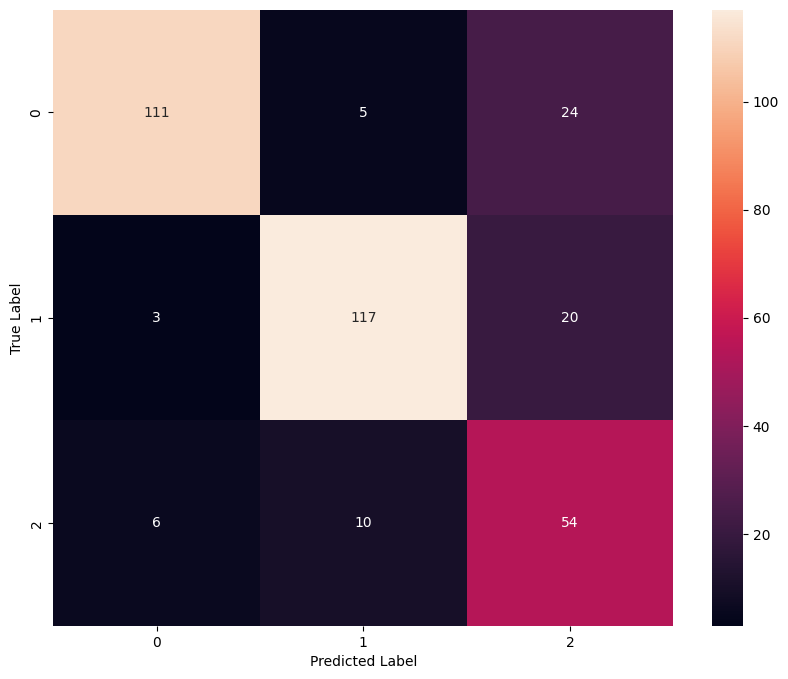

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Try with Word Embeddings

### 1. Import the embeddings

In [4]:
model_loaded = FastText.load("../embeddings/fastText_model")

### 2. Apply the embeddings

In [10]:
# Get the embeddings for each word in the training set
train_embeddings = np.array([model_loaded.wv[word] for word in train_df['text_content']])

# Get the embeddings for each word in the validation set
val_embeddings = np.array([model_loaded.wv[word] for word in val_df['text_content']])

# Get the embeddings for each word in the test set
test_embeddings = np.array([model_loaded.wv[word] for word in test_df['text_content']])

In [15]:
print(f"train_embeddings shape: {train_embeddings.shape}")
print(f"val_embeddings shape: {val_embeddings.shape}")
print(f"test_embeddings shape: {test_embeddings.shape}")

train_embeddings shape: (10000, 128)
val_embeddings shape: (350, 128)
test_embeddings shape: (350, 128)


In [38]:
# Convert the embeddings to dataframes
train_embeddings_df = pd.DataFrame(train_embeddings)
val_embeddings_df = pd.DataFrame(val_embeddings)
test_embeddings_df = pd.DataFrame(test_embeddings)

⚠️ Only execute the cells from the section 3.1 or 3.2, not both.

### 3.1 Predict the label

In [42]:
# convert all the values of the label column that have a value of 3 to 2
X_train = train_embeddings_df
y_train = train_df['label'].replace(3, 2)

X_val = val_embeddings_df
y_val = val_df['label'].replace(3, 2)

X_test = test_embeddings_df
y_test = test_df['label'].replace(3, 2)

### 3.2 Predict the rating

In [43]:
X_train = train_embeddings_df
y_train = train_df['rating']

X_val = val_embeddings_df
y_val = val_df['rating']

X_test = test_embeddings_df
y_test = test_df['rating']

In [44]:
# Only the 'rating' needs to be displaced by 1
# The 'label' already starts at 0
if len(y_train.unique()) == 5:
    # Convert the labels to start from 0 instead of 1
    y_train = y_train - 1
    y_val = y_val - 1
    y_test = y_test - 1

# Display the classes
print(f"Classes: {np.unique(y_train)}")

Classes: [0 1 2 3 4]


### 4. Run "Model" and "Results" sections again